In [2]:
import numpy as np
import sklearn as sk
import pandas as pd
import random
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxx" # username from the json file 
os.environ['KAGGLE_KEY'] = "xxxxxx" # key from the json file
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:08<00:00, 193MB/s]
100% 1.15G/1.15G [00:08<00:00, 141MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip

In [0]:
!unzip chest_xray.zip

**Check out the data and image**

In [5]:
#file directory
train_files = "./chest_xray/train/"
test_files = "./chest_xray/test/"
val_files = "./chest_xray/val/"

#count the num of train files
train_normal_pneumonia = sum([len(files) for r, d, files in os.walk(train_files)])
train_normal = sum([len(files) for r, d, files in os.walk(train_files+"/NORMAL")])
train_pneumonia = sum([len(files) for r, d, files in os.walk(train_files+"/PNEUMONIA")])
print("num of train files: ", train_normal_pneumonia)
print("num of train normal files: ", train_normal)
print("num of train pneumonia files: ", train_pneumonia)

#count the num of test files
test_normal_pneumonia = sum([len(files) for r, d, files in os.walk(test_files)])
test_normal = sum([len(files) for r, d, files in os.walk(test_files+"/NORMAL")])
test_pneumonia = sum([len(files) for r, d, files in os.walk(test_files+"/PNEUMONIA")])
print("num of test files: ", test_normal_pneumonia)
print("num of test normal files: ", test_normal)
print("num of test pneumonia files: ", test_pneumonia)

#count the num of val files
val_normal_pneumonia = sum([len(files) for r, d, files in os.walk(val_files)])
val_normal = sum([len(files) for r, d, files in os.walk(val_files+"/NORMAL")])
val_pneumonia = sum([len(files) for r, d, files in os.walk(val_files+"/PNEUMONIA")])
print("num of val files: ", val_normal_pneumonia)
print("num of val normal files: ", val_normal)
print("num of val pneumonia files: ", val_pneumonia)

num of train files:  5219
num of train normal files:  1342
num of train pneumonia files:  3876
num of test files:  625
num of test normal files:  234
num of test pneumonia files:  390
num of val files:  19
num of val normal files:  9
num of val pneumonia files:  9


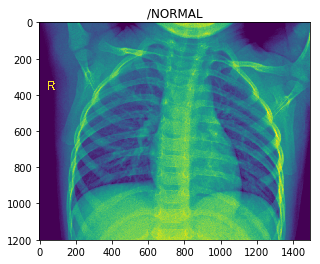

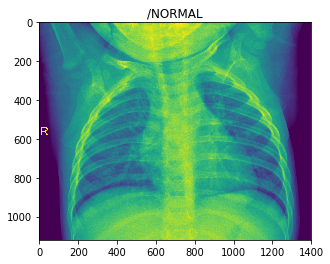

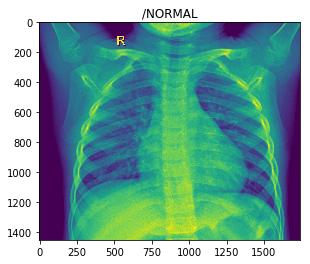

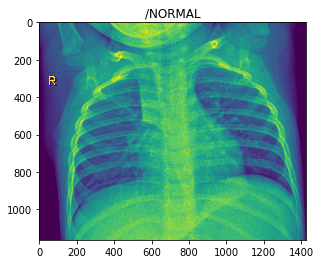

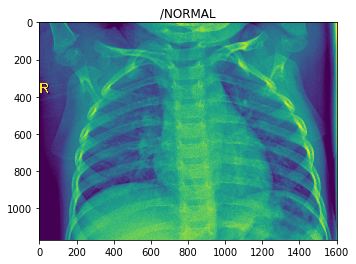

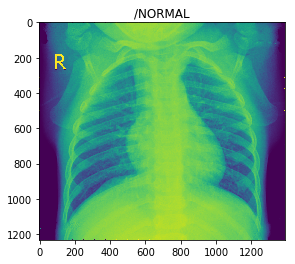

In [106]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#define plot image function
def plot_images(dir, path):
  amount = 0

  for file in os.listdir(dir + path):
    if file.endswith('.jpeg'):
      if amount == 6:
        break

      img = mpimg.imread(os.path.join(dir + path, file))
      plt.figure()
      plt.title(path)
      imgplot = plt.imshow(img)
      amount += 1

plot_images(train_files,"/NORMAL")

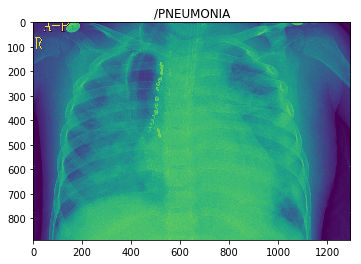

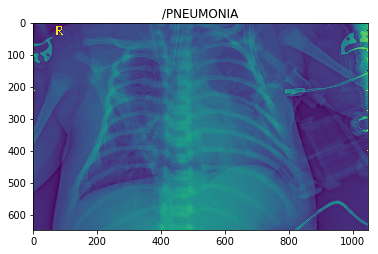

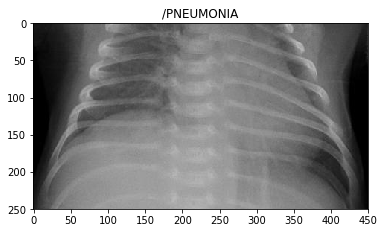

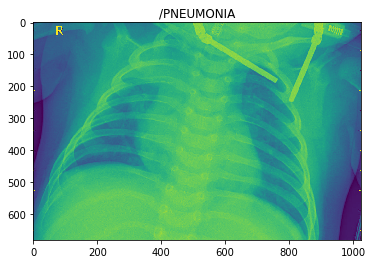

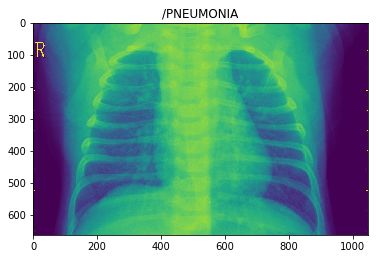

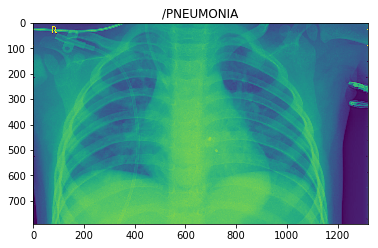

In [107]:
plot_images(train_files,"/PNEUMONIA")

**Train the model**

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, BatchNormalization, Dense, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [62]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 256
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    featurewise_center = True,
    shear_range=0.2,
    horizontal_flip = True,
    validation_split = 0.2,
    rescale=rescale)

validation_datagen = ImageDataGenerator(rescale=rescale)

test_datagen = ImageDataGenerator(rescale=rescale)

# create batch iterators for the train, validation and test data
train_generator = train_datagen.flow_from_directory(
    train_files,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
    val_files,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=val_normal_pneumonia,
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_files,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=test_normal_pneumonia,
    shuffle = False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():
  base_model = InceptionV3(weights="imagenet", include_top=False)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation="relu")(x)
  x = BatchNormalization()(x)
  predictions = Dense(2, activation="softmax")(x) 
  model = Model(inputs=base_model.inputs, outputs=predictions)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  model.summary()
  return model

In [0]:
def get_con_model():
  model = Sequential()
  model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
  model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
  model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
  model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
  model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
  model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2 , activation='softmax'))

  model.summary()
  return model

In [108]:
model = get_model()
# model = get_con_model()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_390 (Conv2D)             (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_380 (BatchN (None, None, None, 3 96          conv2d_390[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, None, None, 3 0           batch_normalization_380[0][0]    
____________________________________________________________________________________________

In [65]:
from tensorflow.keras.optimizers import Adam
model.compile(Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_296 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_285 (BatchN (None, None, None, 3 96          conv2d_296[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, None, None, 3 0           batch_normalization_285[0][0]    
____________________________________________________________________________________________

In [66]:
# defining category label weights as per imbalance amount of the training dataset

from sklearn.utils.class_weight import compute_class_weight

y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight("balanced", labels, y)
train_class_weights

array([1.9448173 , 0.67303226])

In [67]:
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)
print(steps_per_epoch)
print(validation_steps)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 10,
    verbose = 1,
    workers = 20,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    class_weight = train_class_weights
)

21
1


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator

21/21 [==============================] - 361s 17s/step - loss: 1.1111 - acc: 0.6480 - val_loss: 3.1528 - val_acc: 0.5000
Epoch 2/10
21/21 [==============================] - 338s 16s/step - loss: 0.2537 - acc: 0.9101 - val_loss: 0.8612 - val_acc: 0.6875
Epoch 3/10
21/21 [==============================] - 336s 16s/step - loss: 0.1925 - acc: 0.9348 - val_loss: 0.7989 - val_acc: 0.6875
Epoch 4/10
21/21 [==============================] - 337s 16s/step - loss: 0.1635 - acc: 0.9402 - val_loss: 0.9473 - val_acc: 0.6250
Epoch 5/10
21/21 [==============================] - 340s 16s/step - loss: 0.1443 - acc: 0.9436 - val_loss: 1.1581 - val_acc: 0.6250
Epoch 6/10
21/21 [==============================] - 334s 16s/step - loss: 0.1282 - acc: 0.9528 - val_loss: 1.0651 - val_acc: 0.6250
Epoch 7/10
21/21 [==============================] - 333s 16s/step - loss: 0.1134 - acc: 0.9588 - val_loss: 1.0935 - val_acc: 0.5625
Epoch 8/10
21/21 [==============================] - 341s 16s/step - loss: 0.1147 - acc:

In [75]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

1/1 [==============================] - 41s 41s/step - loss: 1.5033 - acc: 0.6907
Loss: 1.503271460533142
Accuracy: 0.6907051


In [92]:
numofbatch = len(test_generator)
batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)
sizeofbatch = len(y_true_batch)
y_pred_batch

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [0]:
#predict
def predict_img(images_path, label):
  amount = 0

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 6:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.figure()

      plt.title("True {} ---- Predict {}".format(label, "NORMAL" if y_pred_batch[amount] == 0 else "PNEUMONIA"))
      imgplot = plt.imshow(img)

      amount += 1

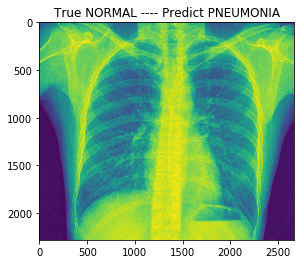

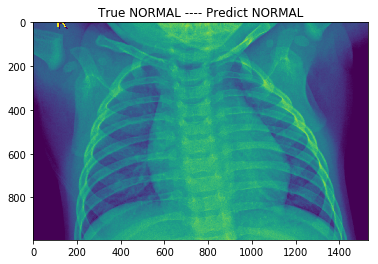

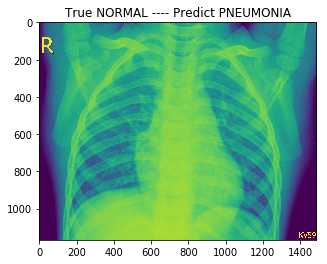

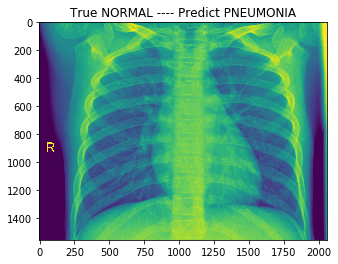

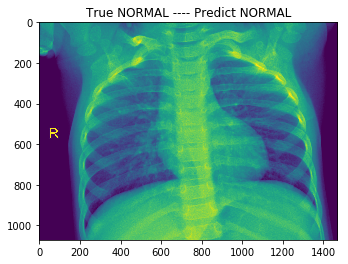

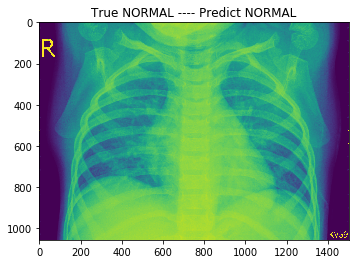

In [105]:
predict_img(test_files+"/NORMAL", "NORMAL")

**Save and load the model**

In [0]:
from tensorflow.keras.models import load_model, save_model

In [0]:
save_model(model, "./model_after_10_epochs", overwrite = True, include_optimizer = True)

In [0]:
theModel = load_model("./model_after_10_epochs")